In [12]:
import xarray as xr
import numpy  as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import os

In [13]:
ff = pd.read_pickle("/glade/work/hpzhang/LCC_pred/data/data_monthly.pkl").dropna()
df  = ff.drop(columns=['lat', 'lon', 'lsm', 'T1000', 'T700', 'EIS', 'ECTEI','ELF','SST', 'AOD', 'TH1000', 'Q1000'])
df = df[df.index.year.isin(np.arange(2003,2019))]
len(df)

5350237

In [14]:
df.head()

,LCF,TH850,TH700,RH1000,RH850,RH700,Q850,Q700,U1000,U700,OMEGA500,OMEGA700,PWV,LH,SH,Tadv,dQ,LTS
time,,,,,,,,,,,,,,,,,,
2003-01-15,0.590822,277.822327,286.950775,85.577278,84.145813,69.974464,0.002045,0.001219,3.637893,6.459276,0.004265,0.005796,8.286732,-14.891875,-1.580903,0.898143,0.001997,13.805145
2003-01-15,0.590822,277.799255,286.895844,85.665604,84.507431,69.732834,0.002052,0.001191,3.618882,6.377827,0.002914,0.010119,8.276699,-13.840185,-0.886921,-0.020427,0.002030,13.703369
2003-01-15,0.556442,277.803558,286.847046,85.945564,84.507431,69.224571,0.002052,0.001163,3.703815,6.273440,0.001923,0.008408,8.276699,-13.721111,-0.987361,-0.006477,0.002075,13.607758
2003-01-15,0.556442,277.851196,286.802826,86.460487,84.855713,69.139580,0.002063,0.001153,3.733388,6.172708,0.005346,0.004445,8.293421,-12.907546,-0.686019,0.069008,0.002108,13.544250
2003-01-15,0.584355,277.882935,286.755585,86.692123,85.037354,69.027931,0.002071,0.001152,3.706906,6.052912,0.009849,0.000932,8.286732,-12.451134,-0.850394,-1.276983,0.002122,13.479095


In [15]:
data = df
index_train = data.index.year.isin(np.arange(2003,2015))
index_test  = data.index.year.isin(np.arange(2015,2019))
data_train = data[index_train]
data_test  = data[index_test]

X_train, y_train = data_train.iloc[:,1:], data_train.iloc[:,0]
X_test, y_test   = data_test.iloc[:,1:], data_test.iloc[:,0]

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [16]:
len(X_train_scaled)*0.8

3208360.0

In [17]:
len(X_train_scaled)*0.2

802090.0

In [18]:
len(X_test_scaled)

1339787

In [19]:
import xgboost as xgb

params =  {'colsample_bylevel': 0.8996518880817399,
 'colsample_bytree': 0.8853387899201755,
 'learning_rate': 0.16184400108442132,
 'max_depth': int(6.970737464733581),
 'n_estimators': int(869.9900903438686),
 'subsample': 0.9239287537315828}

model = xgb.XGBRegressor(tree_method='gpu_hist', 
                        eval_metric=mean_squared_error,
                        gpu_id=0, seed = 1001, n_jobs=-1, **params)
model.fit(X_train_scaled, y_train)

# Predicting the Test set results
y_pred_XGB = model.predict(X_test_scaled)

mse_XGB = mean_squared_error(y_test, y_pred_XGB)
mae_XGB = mean_absolute_error(y_test, y_pred_XGB)
print('Mean squared error using XGBoost: ', mse_XGB)
print('Mean absolute error Using XGBoost: ', mae_XGB)

#Feature ranking...
feature_list = list(data.columns[1:])
feature_imp_XGB = pd.Series(model.feature_importances_, index=feature_list).sort_values(ascending=False)
print(feature_imp_XGB)

Mean squared error using XGBoost:  0.0029772257
Mean absolute error Using XGBoost:  0.041372687
PWV         0.292514
LTS         0.253863
Q850        0.088224
OMEGA500    0.071440
dQ          0.066780
RH850       0.047765
SH          0.032255
TH850       0.028095
Q700        0.025429
U1000       0.019309
Tadv        0.018976
RH1000      0.016616
TH700       0.010068
OMEGA700    0.009120
LH          0.007672
U700        0.006277
RH700       0.005597
dtype: float32


In [20]:
# Predicting the Training set results
y_train_XGB = model.predict(X_train_scaled)

mse_XGB = mean_squared_error(y_train, y_train_XGB)
mae_XGB = mean_absolute_error(y_train, y_train_XGB)
print('Mean squared error using XGBoost: ', mse_XGB)
print('Mean absolute error Using XGBoost: ', mae_XGB)

Mean squared error using XGBoost:  0.002571644
Mean absolute error Using XGBoost:  0.038823485


In [21]:
# We can use the shap package

tmp = pd.DataFrame(X_test_scaled, columns=data.columns[1:])
X_sampled = tmp.sample(1000, random_state=10)

explainer = shap.Explainer(model)
shap_values = explainer(tmp)

# visualize the first prediction's explanation
#shap.plots.waterfall(shap_values[0])


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


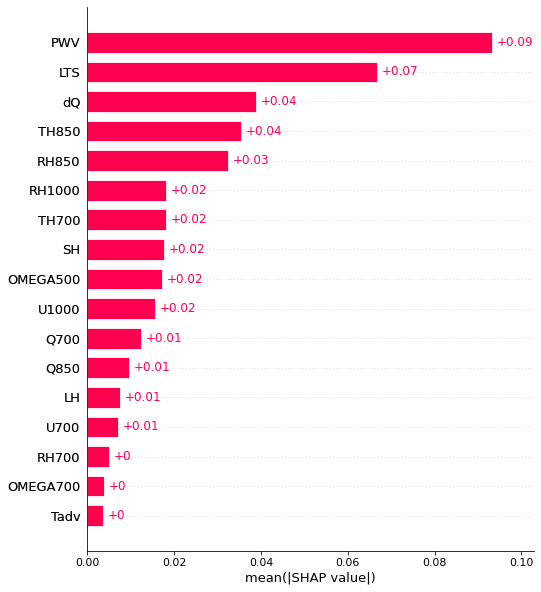

In [22]:
shap.plots.bar(shap_values, max_display=20)

In [23]:
#shap_values

In [24]:
X_sampled

,TH850,TH700,RH1000,RH850,RH700,Q850,Q700,U1000,U700,OMEGA500,OMEGA700,PWV,LH,SH,Tadv,dQ,LTS
472177,-0.020548,0.008190,0.480374,-1.009714,-0.443131,-0.543816,-0.375116,-0.269717,0.311853,0.837915,0.585004,-0.310765,0.573250,0.467907,0.197918,-0.108384,0.291161
843807,-0.617491,-0.578471,-0.586258,-1.024831,-1.229478,-0.968020,-0.970607,0.299060,0.943051,1.669527,0.877699,-0.891527,-0.115543,-0.646221,-0.048771,-0.596454,0.041603
651315,0.335027,0.478917,0.115255,0.677470,-0.364916,0.491980,0.029123,-0.365096,-1.013411,-1.269163,0.105179,0.386834,-0.276858,0.080801,-0.078923,0.455934,0.194482
582148,-0.029063,0.150942,-0.130179,-0.476335,-0.113808,-0.313876,0.008334,-0.791025,1.201322,-0.400969,0.707360,-0.054631,0.167631,0.000430,0.708040,-0.500024,0.948800
1079740,1.033078,0.948596,0.498566,0.660338,1.041225,1.495775,1.688410,-1.083321,-0.603310,0.713539,-0.098748,1.480182,0.532435,0.441361,0.080615,0.884792,-0.267164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
858820,1.092654,0.854416,0.904219,-0.052807,0.459057,1.142924,1.077422,-1.191673,-1.159388,0.201401,0.304306,1.361912,0.223023,0.396385,0.118977,1.641608,-0.901142
129670,1.114271,1.007611,0.148129,0.551117,1.149909,1.562861,1.902908,-0.790212,-0.959789,-0.727760,-1.005620,1.671407,0.018561,0.202463,-0.161229,0.905214,-0.429207
735203,0.516647,0.543503,0.607400,0.307230,0.146399,0.505374,0.427692,-1.651693,-0.446157,-0.293663,-0.079554,0.523981,-0.114183,-0.186118,0.157999,0.309114,0.498667
386933,-0.603025,-0.381064,-2.347061,0.680620,-0.068719,-0.482775,-0.348280,-0.651635,2.064808,0.398941,-0.038769,-0.480008,-0.959237,-1.163836,0.120324,-0.906889,-0.275779
